# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [16]:
%matplotlib inline

In [151]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [24]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.decomposition import PCA

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [11]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

### Perform some basic filtering

In [12]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [13]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [14]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


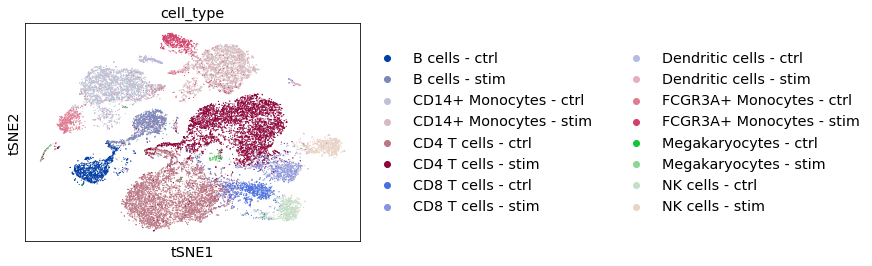

In [17]:
sc.pl.tsne(adata, color='cell_type')

In [18]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


### Some useful functions

In [19]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### Select immune genes using GO annotations

In [19]:
go_annotations = pd.read_csv(data_path + '../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [20]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [21]:
genes_of_interest = list(set(adata.var.index) & set(immune_genes))

In [ ]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(genes_of_interest, f)

### Observed $\mu$-$CV^{2}$ Relationship

In [20]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [21]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim


In [22]:
estimator.estimate_parameters()

In [23]:
estimator.noise_level

0.14298063266117056

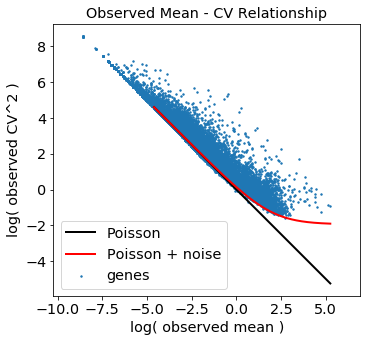

In [24]:
estimator.plot_cv_mean_curve()
#plt.savefig(data_path + 'figures/observed_cv_vs_mean.png', bbox_inches='tight')

### Residual variance

In [23]:
estimator.estimate_parameters()

In [24]:
est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.03336931]


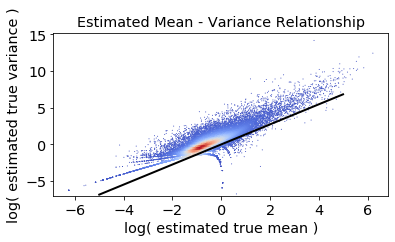

In [28]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*estimator.mean_var_slope
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')
plt.savefig(data_path + 'figures/mean_vs_var.png', bbox_inches='tight')

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.0333693 ]


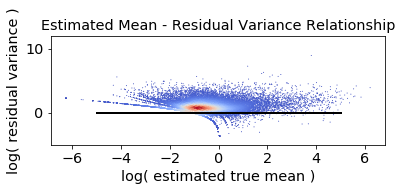

In [29]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - estimator.mean_var_slope*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,12)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')
plt.savefig(data_path + 'figures/mean_vs_res_var.png', bbox_inches='tight')

## Effect of interferon stimulation across cell types

### Read 1D Hypothesis test results and confidence intervals

Make sure that p values are well calibrated.

In [20]:
def get_key(ct):
    return (ct + ' - ctrl', ct + ' - stim')

In [21]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    test_dict = pkl.load(f)

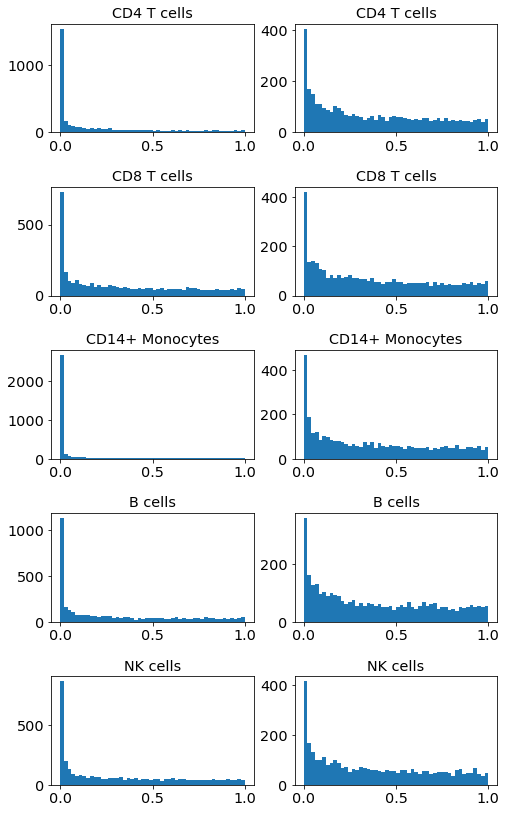

In [54]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells']):
    
    plt.subplot(5, 2, 2*idx+1);
    plt.hist(test_dict[get_key(ct)]['de_pval'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(5, 2, 2*idx+2);
    plt.hist(test_dict[get_key(ct)]['dv_pval'], bins=50);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

### Direct ISRE/GAS genes

Compared to all genes are that upregulated during IFN-B stimulation, genes with ISRE/GAS binding sites are more likely to decrease in variability.

In [95]:
fname1 = 'frontiers_isre_gas_genes.txt'
fname2 = 'reactome_isre_gas_genes.txt'

all_isre_gas_genes = \
    list(set(
        pd.read_csv(fname1, sep='\n', header=None)[0].values.tolist() + \
        pd.read_csv(fname2, sep='\n', header=None)[0].values.tolist()))

In [96]:
isre_gas_genes = []
for gene in adata.var.index:
    
    is_isre_gas = False
    for candidate in all_isre_gas_genes:
        if candidate in gene:
            is_isre_gas = True
    if is_isre_gas:
        isre_gas_genes.append(gene)

In [97]:
isre_gas_idxs = np.where(np.isin(adata.var.index, isre_gas_genes))[0]

In [100]:
ct_dfs = []
for ct in ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']:
    
    # Get upregulated genes
    upreg_genes = utils.get_differential_genes(
        gene_list=adata.var.index.tolist(),
        hypothesis_test_dict=test_dict,
        group_1 = get_key(ct)[0],
        group_2 = get_key(ct)[1],
        which='mean',
        direction='increase',
        sig=0.05,
        num_genes=5000
        )['gene'].tolist()
    upreg_genes = list(set(upreg_genes) - set(isre_gas_genes))
    upreg_gene_idxs = np.where(np.isin(adata.var.index, upreg_genes))[0]
    
    dv_diffs_isre_gas = test_dict[get_key(ct)]['dv_diff'][isre_gas_idxs]
    dv_fdr_isre_gas = test_dict[get_key(ct)]['dv_fdr'][isre_gas_idxs]
    dv_diffs_upreg = test_dict[get_key(ct)]['dv_diff'][upreg_gene_idxs]
    dv_fdr_upreg = test_dict[get_key(ct)]['dv_fdr'][upreg_gene_idxs]
    
    dv_diffs_isre_gas = dv_diffs_isre_gas#[dv_fdr_isre_gas < 1]
    dv_diffs_upreg = dv_diffs_upreg#[dv_fdr_upreg < 1]
    
    isre_gas_df = pd.DataFrame()
    isre_gas_df['dv_diff'] = dv_diffs_isre_gas
    isre_gas_df['dv_fdr'] = dv_fdr_isre_gas
    isre_gas_df['type'] = 'ISRE/GAS'
    
    upreg_df = pd.DataFrame()
    upreg_df['dv_diff'] = dv_diffs_upreg
    upreg_df['dv_fdr'] = dv_fdr_upreg
    upreg_df['type'] = 'upregulated'
    
    combined_df = pd.concat([isre_gas_df, upreg_df])
    combined_df['cell_type'] = ct
    ct_dfs.append(combined_df.copy())
    
    print(
        ct, 
        stats.ttest_ind(
            dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)], 
            dv_diffs_upreg[np.isfinite(dv_diffs_upreg)]))
isre_gas_comparison_df = pd.concat(ct_dfs)
#cts = ['CD4 T cells', 'CD8 T cells', 'NK cells', 'B cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes']

#isre_gas_comparison_df = isre_gas_comparison_df[isre_gas_comparison_df['cell_type'].isin(cts)]

CD4 T cells Ttest_indResult(statistic=-4.952659072474761, pvalue=8.920654884052032e-07)
CD14+ Monocytes Ttest_indResult(statistic=-4.237241043848489, pvalue=2.5057473291681756e-05)
FCGR3A+ Monocytes Ttest_indResult(statistic=-4.905831473325209, pvalue=1.1572509225381613e-06)
NK cells Ttest_indResult(statistic=-2.5875460303677027, pvalue=0.009981478908330097)
CD8 T cells Ttest_indResult(statistic=-0.48851355338288754, pvalue=0.6254479440559951)
B cells Ttest_indResult(statistic=-1.942528403777702, pvalue=0.05256877121062133)


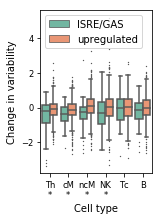

In [216]:
plt.figure(figsize=(2, 3))
sns.boxplot(
    x='cell_type', y='dv_diff', hue='type',
    data=isre_gas_comparison_df,
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th\n*', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.savefig('isre_gas_dv.pdf', bbox_inches='tight')

### Compile 1D hypothesis testing result

In [50]:
def create_1d_df(adata, ct, test_dict):
    
    df = pd.DataFrame()
    gene_list = adata.var.index
    df['gene'] = gene_list
    df['ct'] = ct
    
    for key,val in test_dict[get_key(ct)].items():
        df[key] = val
        
    return df

def assign_quadrant(row):
    
    if row['de_diff'] > 0 and row['dv_diff'] > 0:
        return 'upper_right'
    elif row['de_diff'] > 0 and row['dv_diff'] < 0:
        return 'lower_right'
    elif row['de_diff'] < 0 and row['dv_diff'] > 0:
        return 'upper_left'
    elif row['de_diff'] < 0 and row['dv_diff'] < 0:
        return 'lower_left'
    else:
        return 'None'

In [51]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
df = pd.concat([create_1d_df(adata, ct, test_dict) for ct in cts])
df['quadrant'] = df.apply(assign_quadrant, axis=1)

### Figure out some overall trends regarding the quadrants

- upregulated & decreased variance: ISRE, ISGs
- upregulated & increased variance: metabolism, apoptosis, protein breakdown
- downregulated & increased variance: ribosomal proteins

In [76]:
df_sig = df.query('de_fdr < 0.05 & dv_fdr < 0.15')

In [77]:
df_sig.query('quadrant == "lower_right"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
IFI6      5
IFIT1     4
OAS2      4
IFITM1    4
LY6E      4
IFI44L    4
MX1       4
OAS3      3
RSAD2     3
IL1RN     3
dtype: int64

In [80]:
df_sig.query('quadrant == "upper_right"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
SAT1        5
PRF1        3
CCL2        3
TNFSF10     3
C15orf48    2
PSMA2-1     2
RNF138      2
S100A11     2
FCER1G      2
CCR7        2
dtype: int64

In [83]:
df_sig.query('quadrant == "upper_left"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
RPL5      3
RPL6      3
CXCR4     3
RPS7      3
THBS1     2
PGAM1     2
DDX18     2
S100A8    2
TGFBI     2
BTG1      2
dtype: int64

### Quadrant scatterplots for each cell type

In [149]:
def plot_de_dv(ct, test_dict):
    
    de_diff = test_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff']
    dv_diff = test_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff']
    de_fdr = test_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr']
    dv_fdr = test_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr']
    
    sig = (de_fdr < 0.1) & (dv_fdr < 0.1)
    
    lower_right = adata.var.index[(de_diff > 0) & (dv_diff < 0) & sig]
    upper_right = adata.var.index[(de_diff > 0) & (dv_diff > 0) & sig]
    lower_left = adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig]
    upper_left = adata.var.index[(de_diff < 0) & (dv_diff > 0) & sig]
    
    plt.scatter(de_diff[sig], dv_diff[sig], s=5, color='g')
    plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
    plt.plot([0, 0], [-4, 2.5], '--', lw=2, color='k')
    plt.plot([-3, 5], [0, 0], '--', lw=2, color='k')

    #plt.xlabel('Mean Log-FC');
   # plt.ylabel('Residual variance Log-FC')
    #plt.xlim(-3, 6); plt.ylim(-4, 4)
    plt.title(ct)
    
#     print('lower right', lower_right.tolist())
#     print('upper right', upper_right.tolist())
#     print('lower left', lower_left.tolist())
#     print('upper left', upper_left.tolist())
    #plt.savefig(data_path + 'figures/cd4_2d_changes.pdf', bbox_inches='tight')

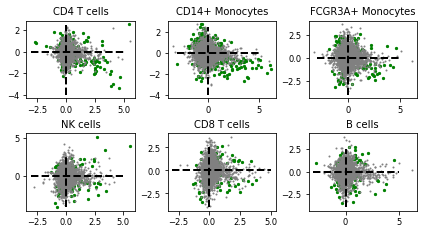

In [159]:
plt.figure(figsize=(7, 3.5))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
for idx, ct in enumerate(cts):
    plt.subplot(2, 3, idx+1)
    plot_de_dv(ct, test_dict)
plt.savefig('de_vs_dv_quadrants.pdf', bbox_inches='tight')

### Expression changes across CT for a gene

In [20]:
adata.var['num'] = np.arange(adata.shape[1])

In [21]:
adata.var.loc['IFI6']

gene_ids    ENSG00000126709
n_counts    59361          
n_cells     2457           
num         66             
Name: IFI6, dtype: object

In [32]:
parameter_dict['CD4 T cells' + ' - ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([3.75603655, 2.0069145 , 2.94908531, ..., 2.53497887, 1.12987436,
        1.90244249]),
 'log_residual_var': array([1.32336429, 0.69659847, 1.08149506, ..., 0.9301853 , 0.12210644,
        0.64313858])}

In [194]:
def plot_exp_changes_across_ct(gene, parameter_dict, ci_dict, barwidth=0.3):
    
    plt.figure(figsize=(3.5, 3))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = cts
    
    labels = ['Th', 'cM', 'ncM', 'NK', 'CD8', 'B']
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([parameter_dict[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([parameter_dict[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([ci_dict[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([ci_dict[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([parameter_dict[group + ' - ctrl']['residual_var'][gene_idx] for group in groups])
    stim_vars = np.array([parameter_dict[group + ' - stim']['residual_var'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([ci_dict[group + ' - ctrl']['log1p_residual_var'][gene_idx] for group in groups])
    stim_vars_ci = np.array([ci_dict[group + ' - stim']['log1p_residual_var'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=2
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Mean')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 4)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=2
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Variability')

In [189]:
across_ct_genes = ['TNFSF10', 'IFI44L', 'TRIM22']

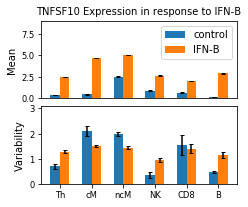

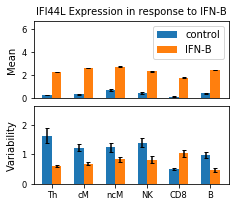

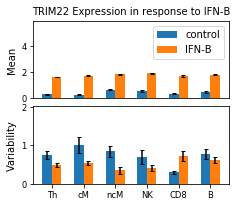

In [195]:
for gene in across_ct_genes:
    try:
        plot_exp_changes_across_ct(gene, parameter_dict, ci_dict)
    except:
        continue
    plt.savefig('de_dv_across_ct_{}.pdf'.format(gene), bbox_inches='tight')

### Expression changes across different genes for a CT

In [272]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = ['IFIT1\n*', 'IFIT2', 'IFIT3', 'IFITM3\n*']
    
    plt.subplot(2, 1, 1)
    plt.title('ISGs in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['ctrl', 'IFN'], loc='upper right')
    plt.ylabel('Mean')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Variability')

### Find some example IFITs

In [273]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3','IFITM3']

In [274]:
df[df['gene'].str.contains('IFIT') & (df['ct'] == 'CD8 T cells')]

,gene,ct,log_mean_1,log_mean_2,log_residual_var_1,log_residual_var_2,de_diff,de_pval,de_fdr,dv_diff,dv_pval,dv_fdr,quadrant
1953,IFIT2,CD8 T cells,-0.899792,2.312949,1.508507,1.032326,3.212740,5.243355e-07,0.000013,-0.476181,0.377978,0.677736,lower_right
1954,IFIT3,CD8 T cells,-0.946312,3.134133,1.912310,1.169554,4.080444,8.017902e-08,0.000007,-0.742756,0.138079,0.441978,lower_right
1955,IFIT1,CD8 T cells,-0.833834,2.966666,1.423369,0.352311,3.800500,1.137227e-08,0.000003,-1.071057,0.004860,0.078847,lower_right
1956,IFIT5,CD8 T cells,-1.351777,0.214775,0.293504,-1.316923,1.566551,7.800828e-07,0.000017,-1.610427,0.001850,0.046950,lower_right
2004,IFITM2,CD8 T cells,1.009750,1.973793,-0.046765,0.125084,0.964043,2.269749e-07,0.000009,0.171849,0.499648,0.763578,upper_right
2005,IFITM1,CD8 T cells,-0.792161,0.777985,-1.163318,-0.769199,1.570146,4.598948e-07,0.000013,0.394118,0.333658,0.646345,upper_right
2006,IFITM3,CD8 T cells,-1.850768,0.763528,0.825043,1.784664,2.614295,7.156241e-07,0.000016,0.959621,0.005810,0.085301,upper_right


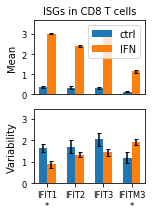

In [275]:
plt.figure(figsize=(2, 3))
plot_exp_across_genes(genes_2, 'CD8 T cells', parameter_dict, ci_dict, barwidth=0.3)
plt.savefig('various_IFITs_CD8.pdf', bbox_inches='tight')

### Individual examples

In [279]:
# Fit scMeMo to figure out the mean-variance relationship

In [280]:
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_parameters()

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim


In [285]:
mean_var_slope = estimator.mean_var_slope
mean_var_inter = estimator.mean_var_inter

In [ ]:
gene = 'IFIT1'
ct = 'CD8 T cells'

In [328]:
M = 1000000
q = 0.01
n = int(M*q)
hyper = stats.hypergeom.rvs(M=M, n=n, N=n, size=100000)
binom = stats.binom.rvs(n, q, size=100000)

In [444]:
def convert_params(mu, theta):
	"""
	Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

	See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
	"""
	r = theta
	var = mu + 1 / r * mu ** 2
	p = (var - mu) / var
	return r, 1 - p

def generate_expected_dist(ct, gene, estimator, size=10000):
    """ Generate an expected distribution given a mean and initial residual variance """

    gene_idx = adata.var.index.tolist().index(gene)
    mean_ctrl = estimator.estimated_central_moments[ct + ' - ctrl']['first'][gene_idx]
    mean_stim = estimator.estimated_central_moments[ct + ' - stim']['first'][gene_idx]
    
    var_ctrl = estimator.estimated_central_moments[ct + ' - ctrl']['second'][gene_idx]
    log_res_var_ctrl = estimator.parameters[ct + ' - ctrl']['log_residual_var'][gene_idx]
    
    var_stim = estimator.estimated_central_moments[ct + ' - stim']['second'][gene_idx]
    expected_log_var_stim = np.log(mean_stim) * estimator.mean_var_slope + estimator.mean_var_inter + log_res_var_ctrl

    expected_var_stim = np.exp(expected_log_var_stim)
    expected_theta_stim = mean_stim**2 / (expected_var_stim - mean_stim)
    
    latent_rvs = stats.nbinom.rvs(*convert_params(mean_stim, expected_theta_stim), size=size)

    m = estimator.beta
    v = estimator.beta_sq - estimator.beta**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    qs = stats.beta.rvs(alpha, beta, size=size)
    
#     observed = [
#         stats.hypergeom.rvs(
#             latent, 
#             int(latent*q), 
#             int(latent*q)) if int(latent*q) > 0 else 0 for latent, q in zip(latent_rvs, qs)]
#     return np.array(observed)

    expected_obs = stats.binom.rvs(latent_rvs, qs)
    expected_freq = np.bincount(expected_obs)/size
    x = np.arange(expected_freq.shape[0])
    
    return np.insert(x, -1, x[-1]), np.insert(expected_freq, 0, expected_freq[0])




In [445]:
gene = 'IFIT1'
ct = 'CD8 T cells'

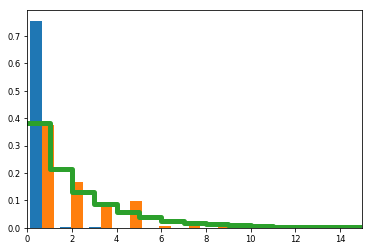

In [455]:
data = get_data(ct, 'IFIT1')
x, expected_freq = generate_expected_dist('CD8 T cells', 'IFIT1', estimator, size=100000)
plt.hist(data, density=True, bins=np.unique(data[1]).shape[0], log=False);
plt.step(x, expected_freq, lw=5)
plt.xlim(0, 15);

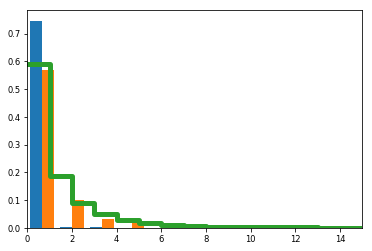

In [454]:
data = get_data(ct, 'IFIT2')
x, expected_freq = generate_expected_dist('CD8 T cells', 'IFIT2', estimator, size=100000)
plt.hist(data, density=True, bins=np.unique(data[1]).shape[0], log=False);
plt.step(x, expected_freq, lw=5)
plt.xlim(0, 15);

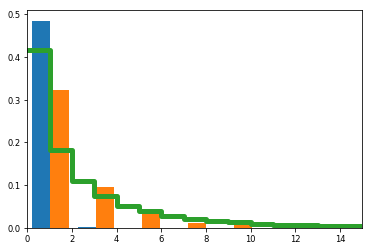

In [456]:
data = get_data(ct, 'IFIT3')
x, expected_freq = generate_expected_dist('CD8 T cells', 'IFIT3', estimator, size=100000)
plt.hist(data, density=True, bins=np.unique(data[1]).shape[0], log=False);
plt.step(x, expected_freq, lw=5)
plt.xlim(0, 15);

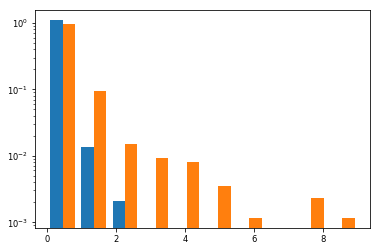

In [278]:
plt.hist(get_data(ct, 'IFITM3'), density=True, bins=10, log=True);